In [1]:
import sys
import operator
import parse as p
import author_network as an
import numpy as np
import networkx as nx
import graphviz as gv
from matplotlib import pyplot as plt
from community import community_louvain
import collections
from node2vec import Node2Vec
p.parse_json('../data/icml2019.json')
p.parse_json('../data/icml2018.json')
p.parse_json('../data/icml2017.json')

### Reading File

In [2]:
temp, temp1 = p.get_paper_count()
authors = temp[0]
counts = temp[1]
sorted_authors = temp1[0]
sorted_counts = temp1[1]

### Author who published the most papers

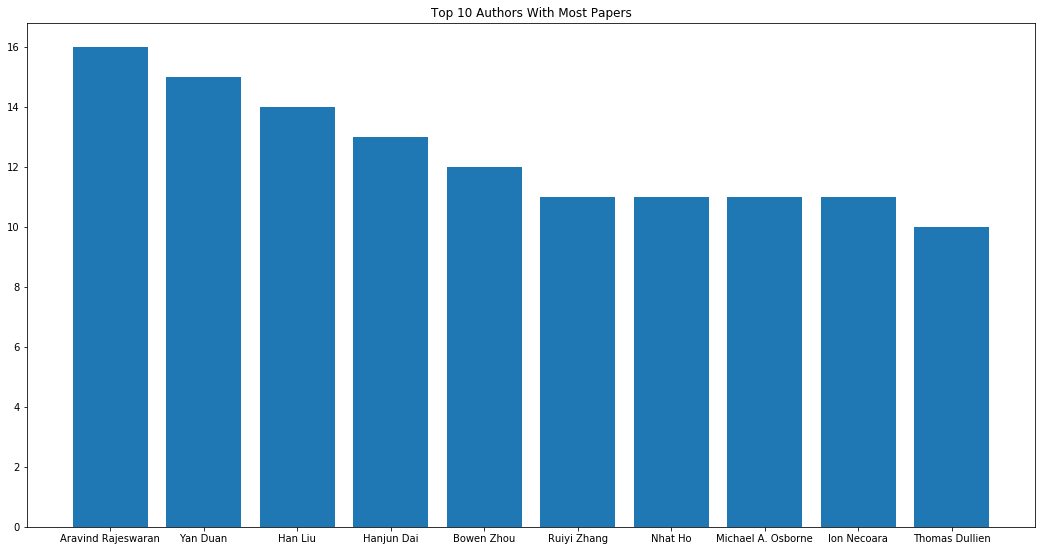

In [3]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_authors[:10],sorted_counts[:10], width = 0.8)
plt.title('Top 10 Authors With Most Papers')
plt.savefig('../image/authors_with_most_papers.png', bbox_inches='tight')
plt.show()

###  Author who has been working with the most people

In [4]:
co_count_authors, co_counts = an.co_worker_counts()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.bar(co_count_authors[:10],co_counts[:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Most Co-workers')
plt.savefig('../image/authors_working_with_most_people.png', bbox_inches='tight')
plt.show()

### Community Detection (Louvain algorithm)

In [5]:
edges, alone = an.get_edges()
G = nx.MultiGraph()
G.add_edges_from(edges)
G.add_nodes_from(alone)
partition = community_louvain.best_partition(G)


In [6]:
# Adding number of papers attribute
for i in range(len(authors)):
    G.nodes[authors[i]]['papers'] = counts[i]
    


In [7]:
values = [partition.get(node) for node in G.nodes()]
counter = collections.Counter(values)


### Author who has been working with the most research groups
### 1) Simply counted version

In [8]:
other_group = an.find_other_group(G, values)
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.bar([x[0] for x in other_group ][:10], [x[1] for x in other_group ][:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Other Research Group Most(simple version)')
plt.savefig('../image/authors_with_most_research_groups_simple.png', bbox_inches='tight')
plt.show()

### 2) Betweeness centrality

In [9]:
G_b = nx.Graph()
G_b.add_edges_from(edges)
G_b.add_nodes_from(alone)

# Adding number of papers attribute
for i in range(len(authors)):
    G_b.nodes[authors[i]]['papers'] = counts[i]

In [10]:
Cb_dict = nx.betweenness_centrality(G_b)
Cb = sorted(Cb_dict.items(), key=operator.itemgetter(1), reverse = True)

In [11]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.bar([x[0] for x in Cb][:10], [x[1] for x in Cb][:10], width = 0.8)
plt.title('Top 10 Authors Who Worked With Other Research Group Most(betweeness centrality)')
plt.savefig('../image/authors_with_most_research_groups_betweeness.png', bbox_inches='tight')
plt.show()

### Network Graph - Louvain algorithm

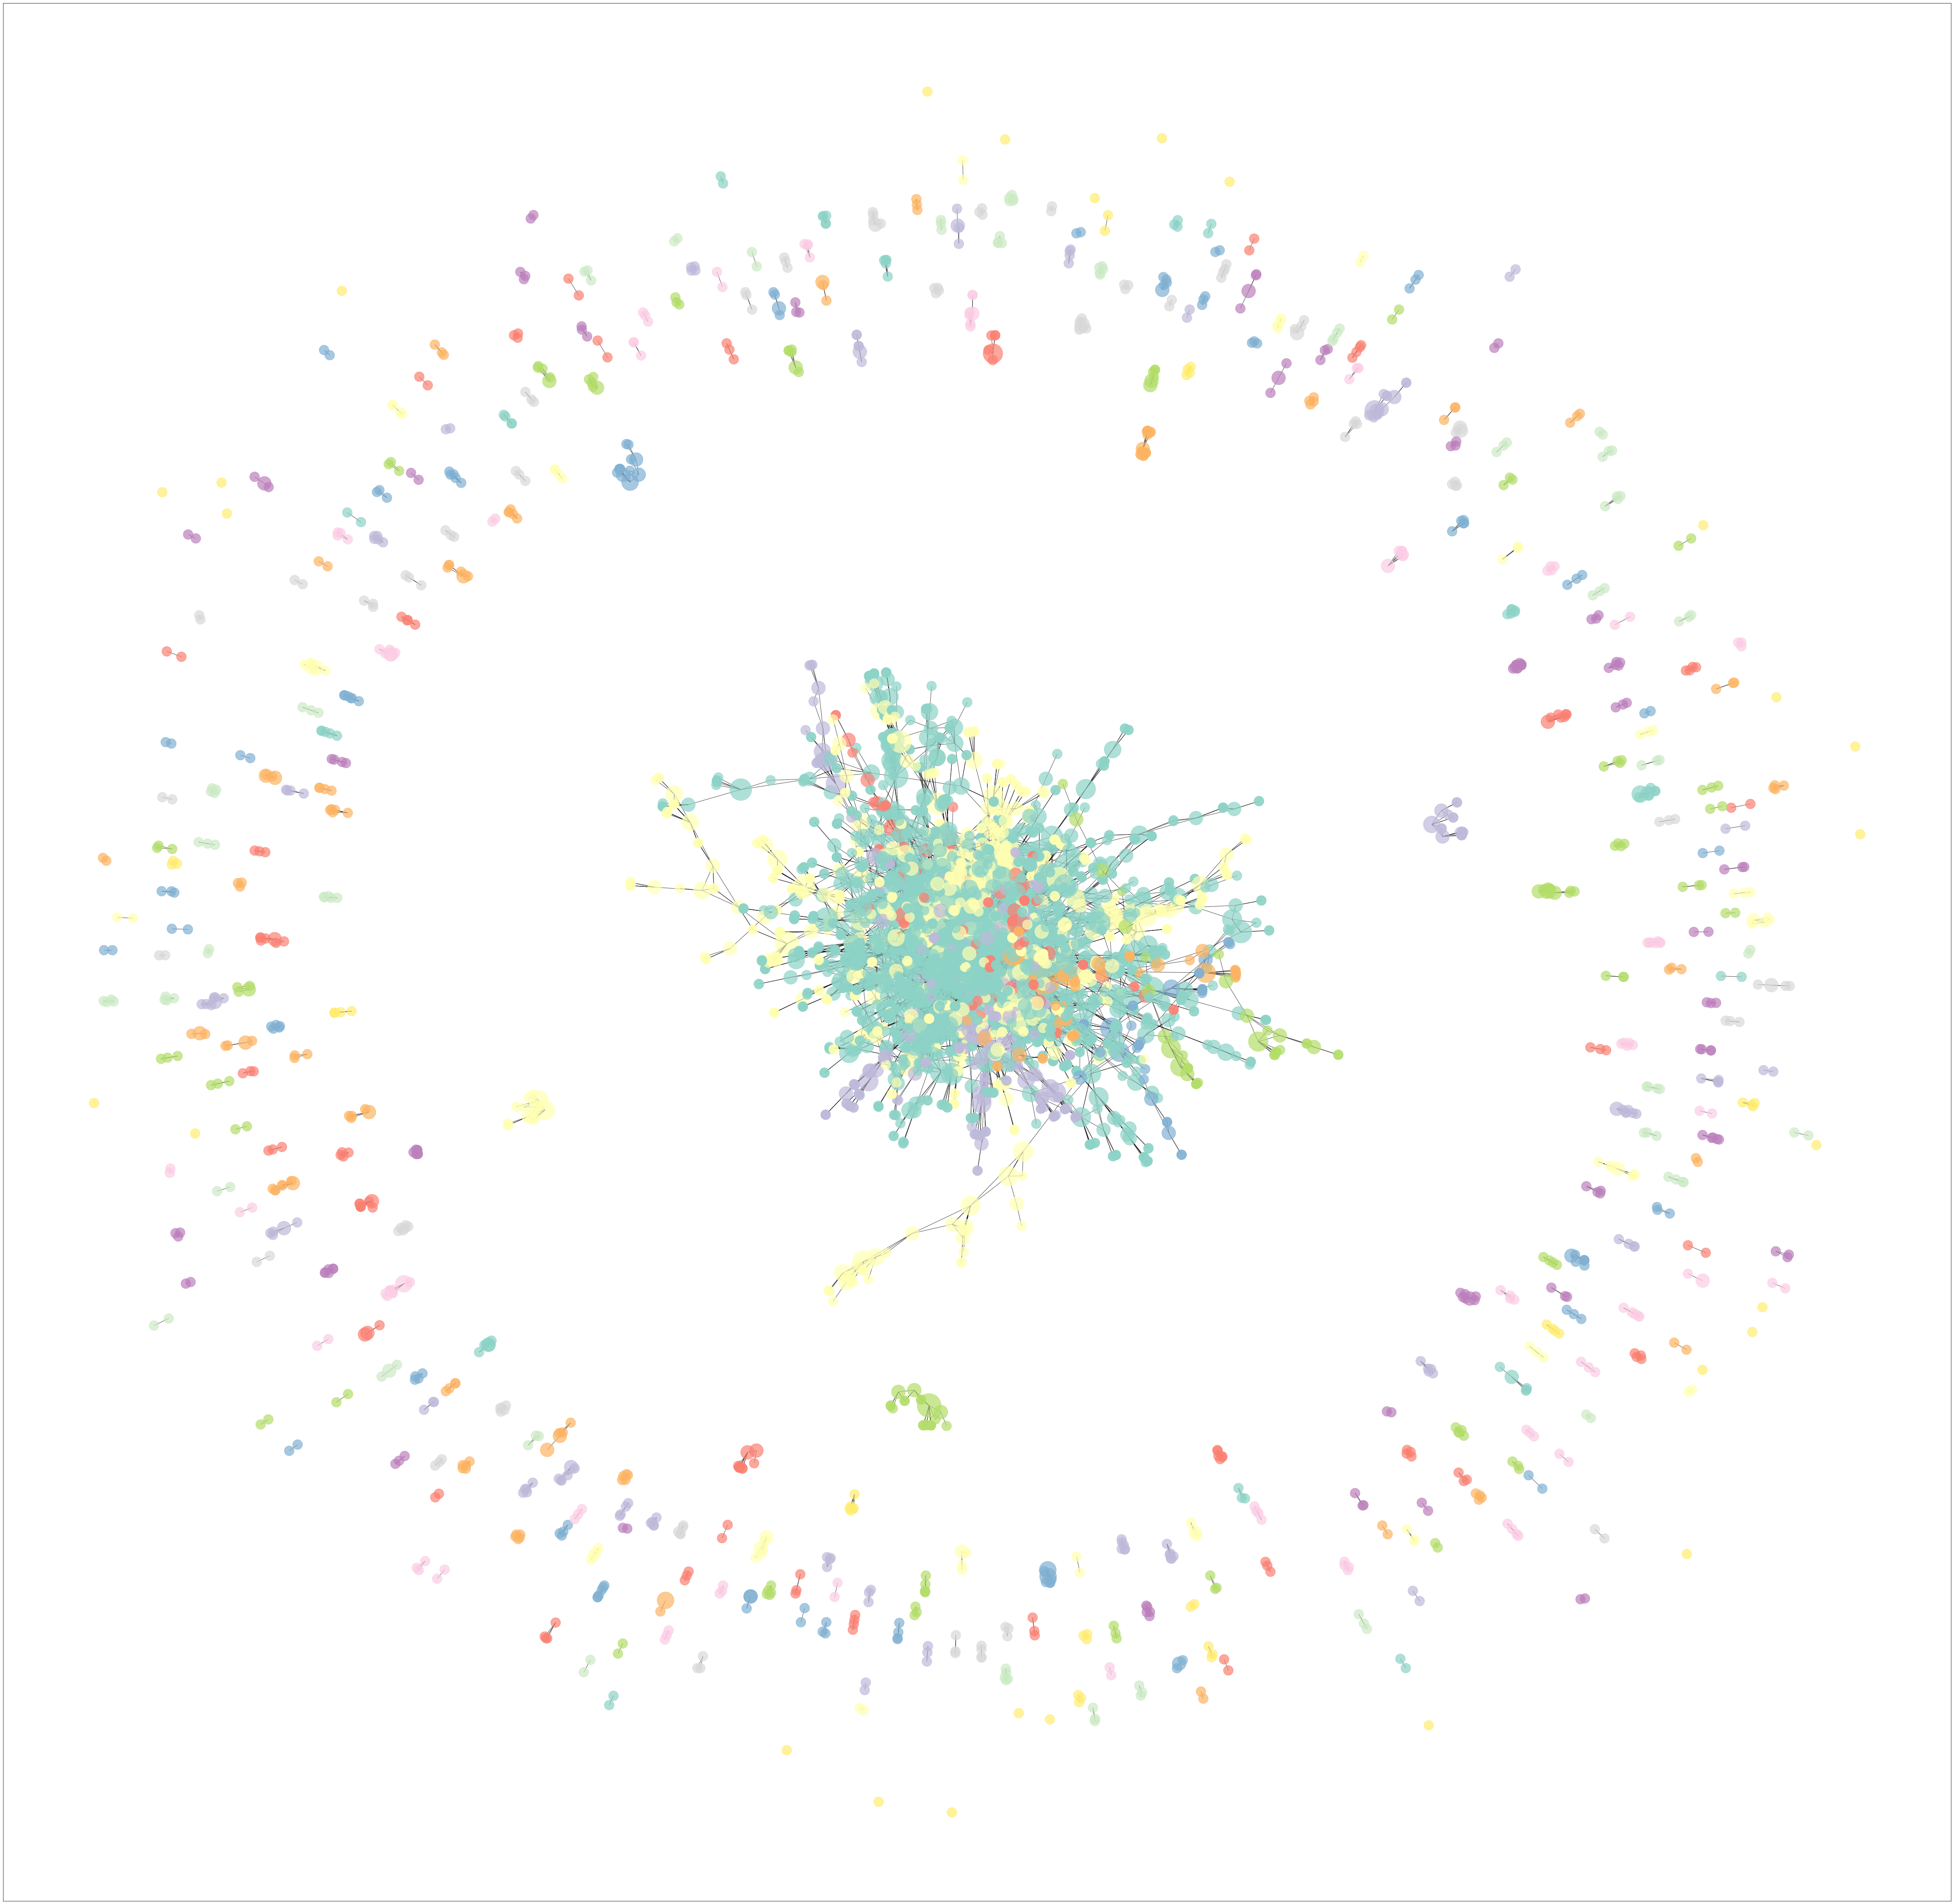

In [12]:
plt.figure(figsize =(80,80))
sp = nx.spring_layout(G)
#node_size = [x for x in G.degree()]
node_size = [500 * nx.get_node_attributes(G, 'papers')[v] for v in G] 
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=node_size,
                 node_color=values, alpha=0.7,cmap = plt.cm.Set3)
# plt.axes('off')
plt.savefig('../image/network_graph_Louvain1.png', bbox_inches='tight')
plt.show()

### Network Graph - node2vec and k-means algorithm

In [13]:
node2vec = Node2Vec(graph=G, # target graph
                    dimensions=50, # embedding dimension
                    walk_length=10, # number of nodes in each walks 
                    p = 1, # return hyper parameter
                    q = 0.0001, # inout parameter, q값을 작게 하면 structural equivalence를 강조하는 형태로 학습됩니다. 
                    weight_key=None, # if weight_key in attrdict 
                    num_walks=2000, 
                    workers=1,
                   )

# 대략 walk들이 어떻게 발생하는지를 아래처럼 볼 수도 있습니다. 
for i, each_walk in enumerate(node2vec.walks):
    print(f"{i:0>2d}, {each_walk}")
    if i>1:
        break

Generating walks (CPU: 1): 100%|██████████| 2000/2000 [2:31:02<00:00,  4.53s/it]      


00, ['Jacob Gardner', 'Andrew Gordon Wilson', 'Christopher Fifty', 'Amauri Souza', 'Polina Kirichenko', 'Himanshu Tyagi', 'Yuwei Hu', 'Himanshu Tyagi', 'Tri Dao', 'Matthew Eichhorn']
01, ['Arthur Mensch', 'Vlad Niculae', 'Arthur Mensch', 'Michael Carbin', 'Charith Mendis', 'Alex Renda', 'Michael Carbin', 'Arthur Mensch', 'Andre Martins', 'Vlad Niculae']
02, ['Yi-An Ma', 'Samuel K. Ainsworth', 'Emily B. Fox', 'Ahmed M. Alaa', 'Emily B. Fox', 'Gerhard Neumann', 'Riad Akrour', 'Gerhard Neumann', 'Mihaela Schaar', 'Gerhard Neumann']


In [14]:
# 발생한 walk를 사용해서 학습을 시켜봅니다. 
# 여기서 fitting할때 사용하는 argument는 gensim의 word2vec과 같습니다. 
# 단 학습시킨 것을 model1처럼 어디에 집어넣어줘야 하는 것 같네요. 여기서 p나 q값을 조절하기는 어려운 것 같습니다. 
model1 = node2vec.fit(window=2)

In [15]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [16]:
model1 = node2vec.fit(window=10)
# kmeans clustering을 진행해줍니다. 

In [17]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=0).fit(model1.wv.vectors)
# node의 cluster 부분을 attrdict에 업데이트해줍니다. 
for n, label in zip(model1.wv.index2entity, kmeans.labels_):
    G.nodes[n]['label'] = label
    

In [18]:
# 그림을 그려줍니다.
plt.figure(figsize=(80, 80))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), node_size=node_size,
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], with_labels=False,
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.savefig('../image/network_graph_node2vec_kmeans.png', bbox_inches='tight')
plt.show()